In [1]:
from eos import cms_eos, aqua_eos, ideal_eos
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from tqdm import tqdm
from scipy.interpolate import RegularGridInterpolator as RGI

erg_to_kbbar = cms_eos.erg_to_kbbar

plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=25)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize=25, direction='in')
plt.rc('ytick', labelsize=25, direction='in')

plt.rc('xtick.major',size=15,pad=8)
plt.rc('xtick.minor',size=7,pad=8)
plt.rc('ytick.major',size=15)
plt.rc('ytick.minor',size=7)

plt.rcParams['axes.grid'] = True

In [23]:
def get_s_h(lgp, lgt):
    if np.isscalar(lgp):
        return float(10**cms_eos.get_s_h_rgi(np.array([lgt, lgp]).T))
    else:
        return 10**cms_eos.get_s_h_rgi(np.array([lgt, lgp]).T)
    
def get_rho_h(lgp, lgt):
    if np.isscalar(lgp):
        return float(cms_eos.get_rho_h_rgi(np.array([lgt, lgp]).T))
    else:
        return cms_eos.get_rho_h_rgi(np.array([lgt, lgp]).T)
    
def get_logu_h(lgp, lgt):
    if np.isscalar(lgp):
        return float(cms_eos.get_logu_h_rgi(np.array([lgt, lgp]).T))
    else:
        return cms_eos.get_logu_h_rgi(np.array([lgt, lgp]).T)
    
def get_s_id(z):
    xz = cms_eos.Y_to_n(z)
    xh = 1 - xz
    return (cms_eos.guarded_log(xh) + cms_eos.guarded_log(xz))/erg_to_kbbar
    
def get_s_pt(lgp, lgt, z, sid=True):
    s_h = get_s_h(lgp, lgt)
    s_z = aqua_eos.get_s_pt_tab(lgp, lgt)
    if sid: return s_h*(1-z) + s_z*z + get_s_id(z)
    else: return s_h*(1-z) + s_z*z
    
def get_rho_pt(lgp, lgt, z):
    rho_h = 10**get_rho_h(lgp, lgt)
    rho_z = 10**aqua_eos.get_rho_pt_tab(lgp, lgt)
    
    return np.log10(1/((1 - z)/rho_h + z/rho_z))

def get_logu_pt(lgp, lgt, z):
    u_h = 10**get_logu_h(lgp, lgt)
    u_z = 10**aqua_eos.get_u_pt_tab(lgp, lgt)

    return np.log10(u_h*(1-z) + u_z*z)

###### error functions ######
def err_t_sp(_lgt, _s, _lgp, _z):
    s_test = get_s_pt(_lgp, _lgt, _z)*erg_to_kbbar
    return (s_test/_s) - 1

def err_p_rhot(_lgp, _lgrho, _lgt, _z):
    rho_test = get_rho_pt(_lgp, _lgt, _z,)
    return (rho_test/_lgrho) - 1

def err_t_srho(_lgt, _s, _lgrho, _z):
    s_test = get_s_rhot_tab(_lgrho, _lgt, _z)*erg_to_kbbar
    return (s_test/_s) - 1

# def err_t_rhop(_lgt, _lgrho, _lgp, _y, _z, hhe_eos, z_eos):
#     logrho_test = get_rho_pt(_lgp, _lgt, _y, _z, hhe_eos, z_eos=z_eos)
#     return (logrho_test/_lgrho) - 1

###### inversion functions ######

TBOUNDS = [2, 7]
PBOUNDS = [0, 15]

XTOL = 1e-16

ideal_xy = ideal_eos.IdealHHeMix(m_he=4)
###### S, P ######

def get_t_sp(_s, _lgp, _z):
    #if alg == 'root':
    if np.isscalar(_s):
        _s, _lgp, _z = np.array([_s]), np.array([_lgp]), np.array([_z])
        guess = ideal_xy.get_t_sp(_s, _lgp, _z)
        sol = root(err_t_sp, guess, tol=1e-8, method='hybr', args=(_s, _lgp, _z))
        return float(sol.x)
    guess = ideal_xy.get_t_sp(_s, _lgp, _z)
    sol = root(err_t_sp, guess, tol=XTOL, method='hybr', args=(_s, _lgp, _z))
    return sol.x
    
def get_p_rhot(_lgrho, _lgt, _z):
    #if alg == 'root':
    if np.isscalar(_lgrho):
        _lgrho, _lgt, _z = np.array([_lgrho]), np.array([_lgt]),np.array([_z])
        guess = ideal_xy.get_p_rhot(_lgrho, _lgt, _z)
        sol = root(err_p_rhot, guess, tol=XTOL, method='hybr', args=(_lgrho, _lgt, _z))
        return float(sol.x)
    guess = ideal_xy.get_p_rhot(_lgrho, _lgt, _z)
    sol = root(err_p_rhot, guess, tol=XTOL, method='hybr', args=(_lgrho, _lgt, _z))
    return sol.x

def get_s_rhot(_lgrho, _lgt, _z):
    logp = get_p_rhot(_lgrho, _lgt, _z)
    return get_s_pt(logp, _lgt, _z)
    
def get_t_srho(_s, _lgrho, _z):
    #if alg == 'root':
    if np.isscalar(_s):
        _s, _lgrho, _z = np.array([_s]), np.array([_lgrho]), np.array([_z])
        guess = ideal_xy.get_t_srho(_s, _lgrho, _z)
        sol = root(err_t_srho, guess, tol=1e-8, method='hybr', args=(_s, _lgrho, _z))
        return float(sol.x)

    guess = ideal_xy.get_t_srho(_s, _lgrho, _z)
    sol = root(err_t_srho, guess, tol=1e-8, method='hybr', args=(_s, _lgrho, _z))
    return sol.x

get_s_pt(6, get_t_sp(6, 6, 0.02), 0.02)#*erg_to_kbbar

# get_rho_pt(get_p_rhot(-4, 3, 0.02), 3, 0.02)

get_rho_pt(get_p_rhot(-4, get_t_srho(6, -4, 0.02), 0.02), get_t_srho(6, -4, 0.02), 0.02)

-3.9999999999999996

In [3]:
logpgrid = np.arange(5, 14.05, 0.05)
sgrid = np.arange(5.0, 10.05, 0.05)
ygrid = np.arange(0.05, 1.0, 0.05)

logt_res = []
logrho_res = []
for s in tqdm(sgrid):
    s_ = np.full_like(ygrid, s)
    logt_s = []
    logrho_s = []
    for p in logpgrid:
        logp = np.full_like(ygrid, p)
        logt = get_t_sp(s_, logp, ygrid)
        logrho = get_rho_pt(logp, logt, ygrid)

        logrho_s.append(logrho)
        logt_s.append(logt)

    logrho_res.append(logrho_s)
    logt_res.append(logt_s)

100%|██████████| 102/102 [08:20<00:00,  4.91s/it]


In [7]:
zvals_sp = ygrid
svals_sp = sgrid
logpvals_sp = logpgrid


get_rho_rgi_sp = RGI((svals_sp, logpvals_sp, zvals_sp), logrho_res, method='linear', \
            bounds_error=False, fill_value=None)
get_t_rgi_sp = RGI((svals_sp, logpvals_sp, zvals_sp), logt_res, method='linear', \
            bounds_error=False, fill_value=None)

def get_rho_sp_tab(s, p, z):
    if np.isscalar(s):
        return float(get_rho_rgi_sp(np.array([s, p, z]).T))
    else:
        return get_rho_rgi_sp(np.array([s, p, z]).T)

def get_t_sp_tab(s, p, z):
    if np.isscalar(s):
        return float(get_t_rgi_sp(np.array([s, p, z]).T))
    else:
        return get_t_rgi_sp(np.array([s, p, z]).T)

In [8]:
np.save('eos/h_aqua/sp_base.npy', [logrho_res, logt_res])

In [14]:
logrhovals_rhot = np.linspace(-5, 1.5, 100)
logtvals_rhot = np.arange(2.1, 5.1, 0.05)
yvals_rhot = np.arange(0.05, 1.0, 0.05)

logp_res = []
s_res = []
for rho in tqdm(logrhovals_rhot):
    rho_ = np.full_like(yvals_rhot, rho)
    logp_t = []
    s_t = []
    for t in logtvals_rhot:
        logt = np.full_like(yvals_rhot, t)

        logp = get_p_rhot(rho_, logt, yvals_rhot)
        s = get_s_pt(logp, logt, yvals_rhot)

        logp_t.append(logp)
        s_t.append(s)

    logp_res.append(logp_t)
    s_res.append(s_t)

100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


In [15]:
np.save('eos/h_aqua/rhot_base.npy', [logp_res, s_res])

In [24]:
get_p_rgi_rhot = RGI((logrhovals_rhot, logtvals_rhot, yvals_rhot), logp_res, method='linear', \
            bounds_error=False, fill_value=None)
get_s_rgi_rhot = RGI((logrhovals_rhot, logtvals_rhot, yvals_rhot), s_res, method='linear', \
            bounds_error=False, fill_value=None)

def get_p_rhot_tab(rho, t, y, z=0.0):
    if np.isscalar(rho):
        return float(get_p_rgi_rhot(np.array([rho, t, y]).T))
    else:
        return get_p_rgi_rhot(np.array([rho, t, y]).T)

def get_s_rhot_tab(rho, t, y, z=0.0):
    if np.isscalar(rho):
        return float(get_s_rgi_rhot(np.array([rho, t, y]).T))
    else:
        return get_s_rgi_rhot(np.array([rho, t, y]).T)

In [26]:
svals_srho = np.arange(5.0, 9.05, 0.05)
logrhovals_srho = np.linspace(-5, 2.0, 100)
yvals_srho = np.arange(0.05, 1.0, 0.05)

logt_res_srho = []
logp_res_srho = []

for s in tqdm(svals_srho):
    s_ = np.full_like(yvals_srho, s)
    logt_rho = []
    logp_rho = []
    for rho in logrhovals_srho:
        logrho = np.full_like(yvals_srho, rho)
        logt = get_t_srho(s_, logrho, yvals_srho)
        logp = get_p_rhot_tab(logrho, logt, yvals_srho)

        logt_rho.append(logt)
        logp_rho.append(logp)

    logt_res_srho.append(logt_rho)
    logp_res_srho.append(logp_rho)

100%|██████████| 82/82 [15:30<00:00, 11.35s/it]


In [27]:
np.save('eos/h_aqua/srho_base.npy', [logp_res_srho, logt_res_srho])

# Testing file

In [3]:
from eos import h_aqua_eos

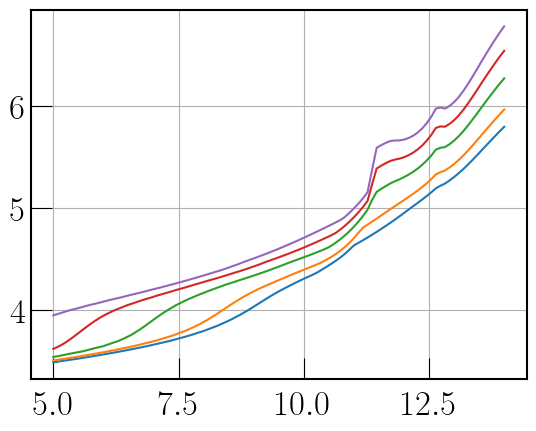

In [5]:
sgrid = [5.5, 6, 7, 8, 9]
logpgrid = np.linspace(5, 14, 100)
zval = np.full_like(logpgrid, 0.75) # Z = 0.25

for s in sgrid:
    sval = np.full_like(logpgrid, s)
    rho, t = h_aqua_eos.get_rhot_sp_tab(sval, logpgrid, zval)
    
    plt.plot(logpgrid, t)